In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [14]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [44]:
t = pd.read_csv('/home/mrrumpf/build/planb/vscode-template-linux/2338365-no-nans.csv')
df = t[['DATE','HourlyDryBulbTemperature']]
print(df)

                      DATE  HourlyDryBulbTemperature
0      2015-01-01T00:53:00                        40
1      2015-01-01T01:53:00                        39
2      2015-01-01T02:53:00                        39
3      2015-01-01T03:53:00                        39
4      2015-01-01T04:53:00                        39
...                    ...                       ...
68814  2020-10-29T19:53:00                        64
68815  2020-10-29T20:53:00                        62
68816  2020-10-29T21:53:00                        61
68817  2020-10-29T22:53:00                        60
68818  2020-10-29T23:53:00                        59

[68819 rows x 2 columns]


In [45]:
uni_data = df['HourlyDryBulbTemperature']
uni_data.index = df['DATE']
uni_data.head()

DATE
2015-01-01T00:53:00    40
2015-01-01T01:53:00    39
2015-01-01T02:53:00    39
2015-01-01T03:53:00    39
2015-01-01T04:53:00    39
Name: HourlyDryBulbTemperature, dtype: int64

array([<AxesSubplot:xlabel='DATE'>], dtype=object)

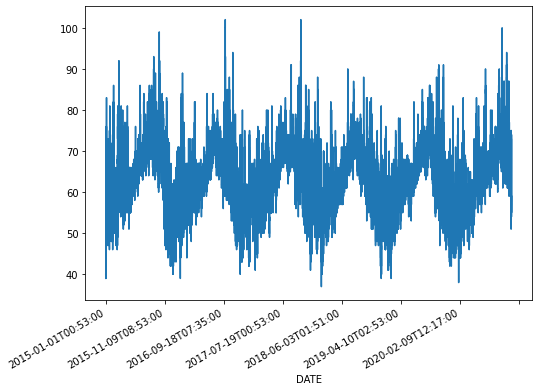

In [46]:
uni_data.plot(subplots=True)

In [47]:
uni_data = uni_data.values

In [49]:
# 2121 datapoints (days)
# .70 == training data = 1484
# .15 == validation data = 318
# .15 == test data = 318
TRAIN_SPLIT = 48000

In [50]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [51]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [63]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [64]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-3.12743651]
 [-3.26373708]
 [-3.26373708]
 [-3.26373708]
 [-3.26373708]
 [-3.26373708]
 [-3.26373708]
 [-2.71853479]
 [-2.03703193]
 [-1.49182964]
 [-1.2192285 ]
 [-0.81032678]
 [-0.94662735]
 [-0.94662735]
 [-0.94662735]
 [-1.08292792]
 [-1.35552907]
 [-1.76443079]
 [-2.03703193]
 [-2.03703193]]

 Target temperature to predict
-2.1733325020993792


In [65]:
def create_time_steps(length):
  return list(range(-length, 0))

In [66]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/home/mrrumpf/venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

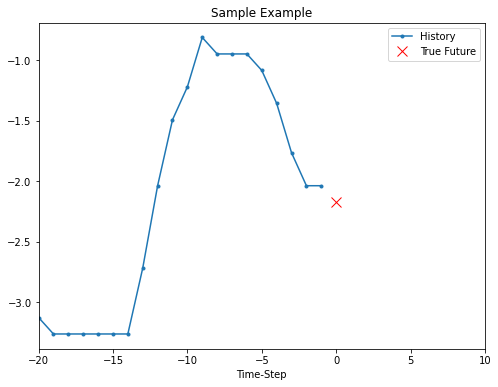

In [67]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')


In [68]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/home/mrrumpf/venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

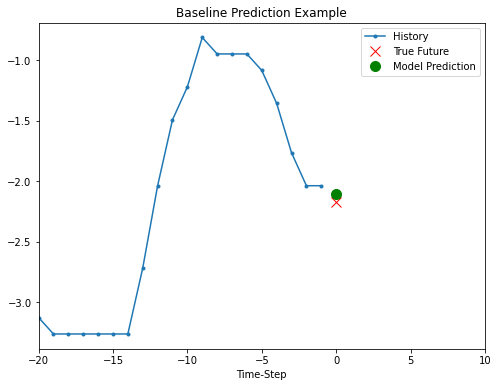

In [69]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [73]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [74]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [75]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [76]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 2s 9ms/step - loss: 0.4266 - val_loss: 0.2926
Epoch 2/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2260 - val_loss: 0.1623
Epoch 3/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1456 - val_loss: 0.1311
Epoch 4/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1319 - val_loss: 0.1275
Epoch 5/10
200/200 [==============================] - 1s 7ms/step - loss: 0.1294 - val_loss: 0.1239
Epoch 6/10
200/200 [==============================] - 2s 12ms/step - loss: 0.1276 - val_loss: 0.1227
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 0.1263 - val_loss: 0.1211
Epoch 8/10
200/200 [==============================] - 2s 10ms/step - loss: 0.1250 - val_loss: 0.1204
Epoch 9/10
200/200 [==============================] - 3s 13ms/step - loss: 0.1252 - val_loss: 0.1201
Epoch 10/10
200/200 [==============================] - 2s 12ms/step - loss: 0.1248 - val_loss: 0

In [78]:
simple_lstm_model.save('/home/mrrumpf/build/planb/vscode-template-linux/planb.tfmodel')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/mrrumpf/build/planb/vscode-template-linux/planb.tfmodel/assets


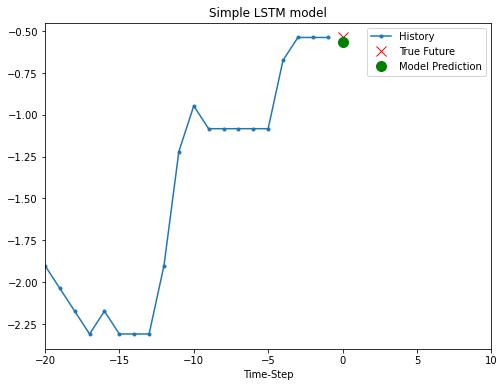

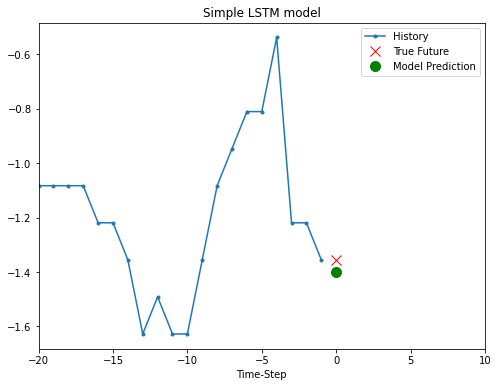

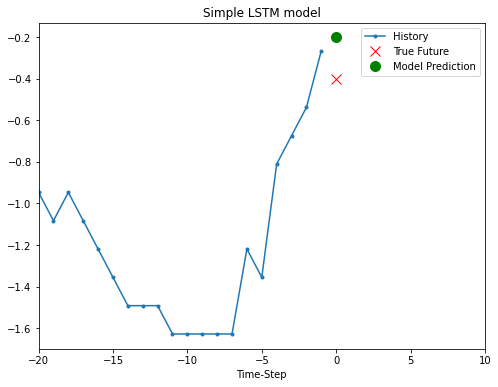

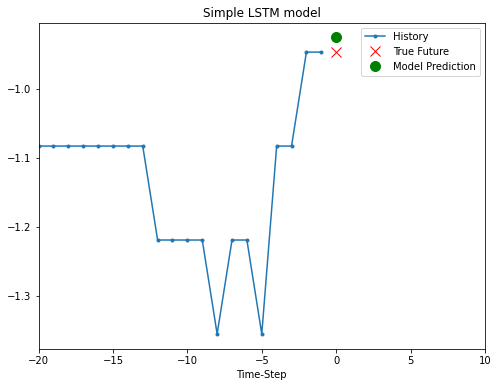

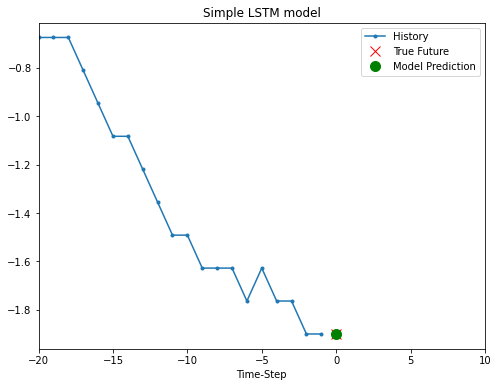

In [77]:
for x, y in val_univariate.take(5):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

In [79]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_saved_model("/home/mrrumpf/build/planb/vscode-template-linux/planb.tfmodel")
model_no_quant_tflite = converter.convert()

# Save the model to disk
open("/home/mrrumpf/build/planb/vscode-template-linux/planb.tflite", "wb").write(model_no_quant_tflite)

21048